In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import MinMaxScaler
import chow_test as chowtest
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests

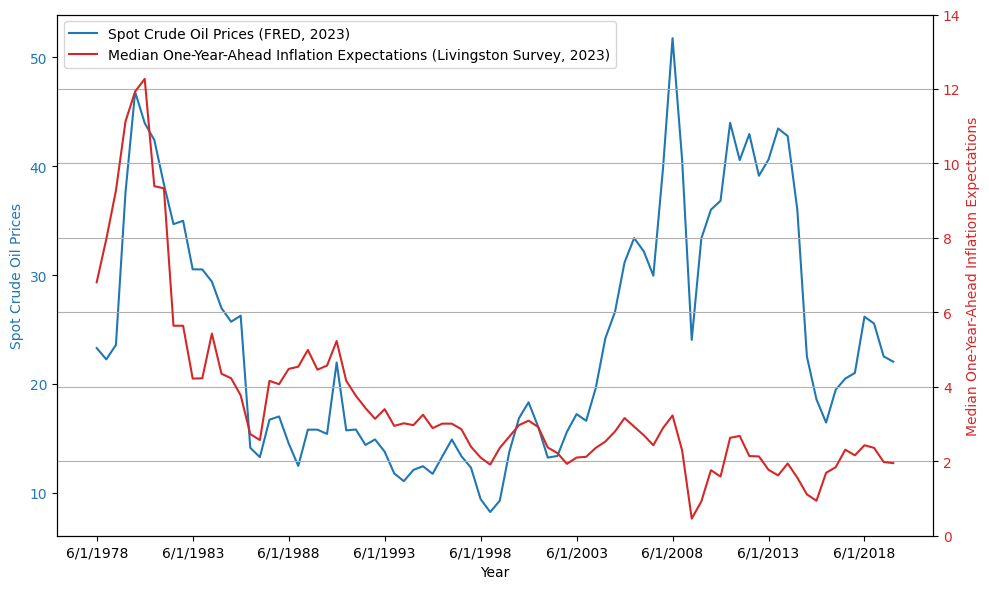

In [2]:
# Input the csv data
data = pd.read_csv("final data.csv")

years = data['Date']
inflation_expectations = data['Inflation Expectations']
oil_prices = data['Oil Prices']

# Plot oil prices on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(years, oil_prices, color='tab:blue', label='Spot Crude Oil Prices (FRED, 2023)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Spot Crude Oil Prices', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot inflation expectations on the right y-axis
ax2 = ax1.twinx()


ax2.plot(years, inflation_expectations, color='tab:red', 
         label='Median One-Year-Ahead Inflation Expectations (Livingston Survey, 2023)')
ax2.set_ylabel('Median One-Year-Ahead Inflation Expectations', color='tab:red')
ax2.set_ylim(0, 14)  
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.xticks(np.arange(0, len(years), 10))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.tight_layout()
# plt.savefig('oil.png', dpi = 300)

In [3]:
# Output normalized spread
scaler = MinMaxScaler()

inflation_array = inflation_expectations.to_numpy().reshape(-1, 1)
oil_prices_array = oil_prices.to_numpy().reshape(-1, 1)

normalized_var1 = scaler.fit_transform(inflation_array)
normalized_var2 = scaler.fit_transform(oil_prices_array)

spread = normalized_var1 - normalized_var2
spread_series = pd.Series(spread.flatten())

In [4]:
# Integer representation of years
years_int = pd.DataFrame({'Index': range(84)})

In [5]:
# Chow test:
p_valueList = []
for i in range(1, len(spread)-1):
    print("Index:", i)
    chow_statistic, p_value = chowtest.chow_test(years_int, spread_series, i, i+1, 0.05)
    p_valueList.append(p_value)
index_break = p_valueList.index(min(p_valueList))+1 # plus one because we started from 1, not 0

Index: 1
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.14495903703827215, P_value: 0.8652872925130268
Index: 2
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.6354632394727748, P_value: 0.5323756952115655
Index: 3
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.666532620935538, P_value: 0.5163494691652141
Index: 4
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.4855386542897101, P_value: 0.6171897683211345
Index: 5
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.2096799286311056, P_value: 0.8112935232244034
Index: 6
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.6176578448887912, P_value: 0.541789096418158

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 39.77191959708896, P_value: 1.1229905894083458e-12
Index: 57
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 38.52273642293817, P_value: 2.103095475547434e-12
Index: 58
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 39.99552638877591, P_value: 1.0047518372857667e-12
Index: 59
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 38.72723949870531, P_value: 1.8964829706646924e-12
Index: 60
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 32.05354999116716, P_value: 6.42175201903683e-11
Index: 61
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 20.26574814290327, P_value: 7.865331719258961e-08
Index: 62
Reject the null hypothesis

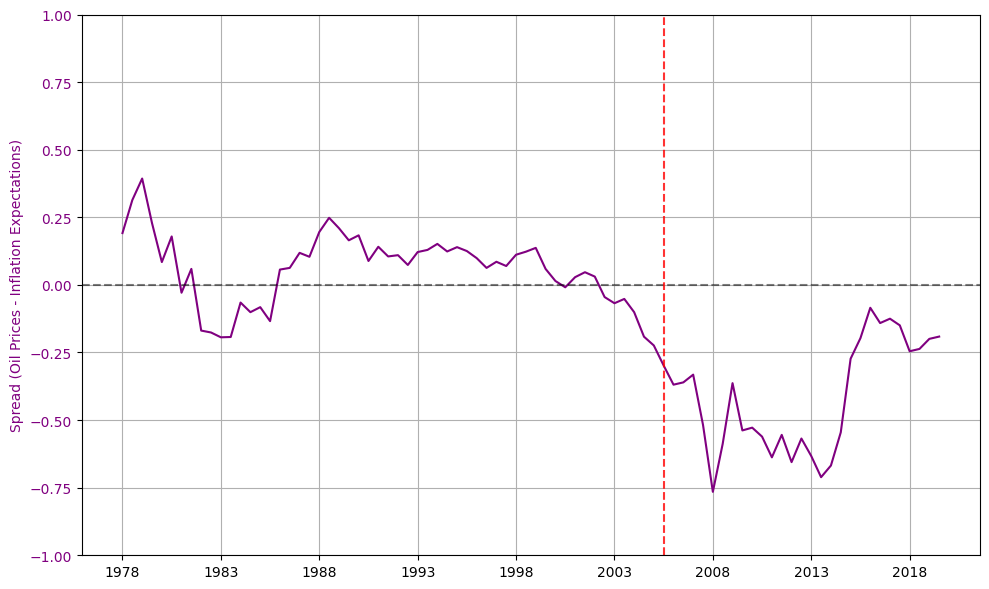

In [16]:
# Set 55 as the threshold for structural break
years = np.arange(1978, 2020, 0.5)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(years, spread, color='purple', label='Normalized Spread (Oil Prices - Inflation Expectations)')
ax1.set_ylabel('Spread (Oil Prices - Inflation Expectations)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)  
ax1.set_ylim(-1, 1)
plt.grid(True)
plt.tight_layout()
x_value = years[index_break]
plt.xticks(np.arange(1978, 2022, 5)) 
ax1.axvline(x_value, color='red', linestyle='--', alpha=0.8, label=f'Vertical Line at x={x_value}')
plt.show()

Regression Line Equations:
Spread Before = -0.0039 * Year + 7.7919
Spread After = 0.0238 * Year + -48.2212


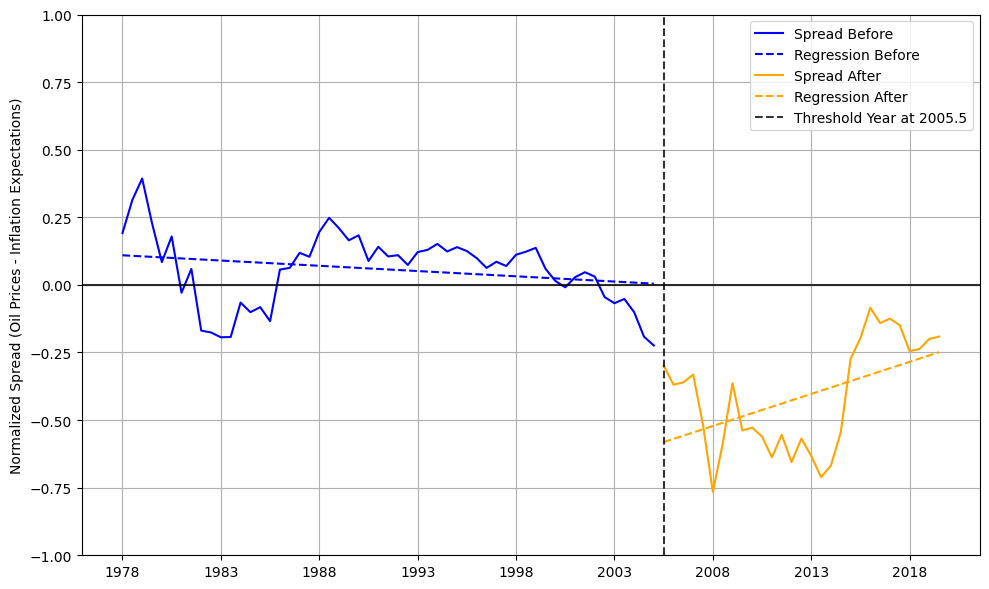

In [20]:
years = np.arange(1978, 2020, 0.5)  # assuming half-year intervals

# Threshold for splitting data
threshold_year = years[index_break] 

# Split data based on the threshold
years_before = years[years < threshold_year]
spread_before = spread[:len(years_before)]

years_after = years[years >= threshold_year]
spread_after = spread[len(years_before):]

# Fit linear regression models
regression_before = LinearRegression().fit(years_before.reshape(-1, 1), spread_before)
regression_after = LinearRegression().fit(years_after.reshape(-1, 1), spread_after)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot spread and regression line before threshold
ax1.plot(years_before, spread_before, color='blue', label='Spread Before')
ax1.plot(years_before, regression_before.predict(years_before.reshape(-1, 1)), color='blue', linestyle='--', label='Regression Before')

# Plot spread and regression line after threshold
ax1.plot(years_after, spread_after, color='orange', label='Spread After')
ax1.plot(years_after, regression_after.predict(years_after.reshape(-1, 1)), color='orange', linestyle='--', label='Regression After')

coef_before = regression_before.coef_[0]
intercept_before = regression_before.intercept_
coef_after = regression_after.coef_[0]
intercept_after = regression_after.intercept_

# Convert coefficients and intercepts to regular Python floats
coef_before_float = float(coef_before)
intercept_before_float = float(intercept_before)
coef_after_float = float(coef_after)
intercept_after_float = float(intercept_after)

# Output regression line equations
equation_before = f"Spread Before = {coef_before_float:.4f} * Year + {intercept_before_float:.4f}"
equation_after = f"Spread After = {coef_after_float:.4f} * Year + {intercept_after_float:.4f}"

print("Regression Line Equations:")
print(equation_before)
print(equation_after)

ax1.set_ylabel('Normalized Spread (Oil Prices - Inflation Expectations)')
ax1.axhline(0, color='black', alpha=0.8)
ax1.set_ylim(-1, 1)  # Adjust y-axis limits as needed
plt.grid(True)
plt.xticks(np.arange(1978, 2022, 5))  # Adjust x-axis ticks as needed
ax1.axvline(threshold_year, color='black', linestyle='--', alpha=0.8, label=f'Threshold Year at {threshold_year}')
plt.legend()
plt.tight_layout()
plt.show()



In [8]:
# Dataset preparation
inflation_expectations = data['Inflation Expectations']
oil_prices = data['Oil Prices']
oil_prices_diff = oil_prices.diff().dropna()
inflation_expectations_diff = inflation_expectations.diff().dropna()

rawFirstSCOP = oil_prices[0:55]
rawSecondSCOP = oil_prices[55:]
rawFirstMOIE = inflation_expectations[0:55]
rawSecondMOIE = inflation_expectations[55:]
diffFirstSCOP = oil_prices_diff[0:55]
diffSecondSCOP = oil_prices_diff[55:]
diffFirstMOIE = inflation_expectations_diff[0:55]
diffSecondMOIE = inflation_expectations_diff[55:]

In [9]:
# ADF tests
datasetList = [("raw first SCOP", rawFirstSCOP), 
               ("raw second SCOP", rawSecondSCOP), 
               ("raw first MOIE", rawFirstMOIE), 
               ("raw second MOIE", rawSecondMOIE), 
               ("diff first SCOP", diffFirstSCOP), 
               ("diff second SCOP", diffSecondSCOP), 
               ("diff first MOIE", diffFirstMOIE), 
               ("diff second MOIE", diffSecondMOIE)]

for i in range(len(datasetList)):
    name, dataset = datasetList[i]
    print(name)
    
    adftest = adfuller(dataset, autolag='AIC', regression='c')
    print("No trend")
    print("ADF-Statistic:", round(adftest[0], 3))
    print("P-Value:", round(adftest[1], 3))
    
    adftest = adfuller(dataset, autolag='AIC', regression='ct')
    print("Trend")
    print("ADF-Statistic:", round(adftest[0], 3))
    print("P-Value:", round(adftest[1], 3))
    
    print("\n")
    
# adftest = adfuller(oil_prices, autolag='AIC', regression='ct')
# print("ADF Test Results")
# print("Null Hypothesis: The series has a unit root (non-stationary)")
# print("ADF-Statistic:", adftest[0])
# print("P-Value:", adftest[1])
# print("Number of lags:", adftest[2])
# print("Number of observations:", adftest[3])
# print("Critical Values:", adftest[4])
# print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

raw first SCOP
No trend
ADF-Statistic: -1.37
P-Value: 0.596
Trend
ADF-Statistic: -1.254
P-Value: 0.899


raw second SCOP
No trend
ADF-Statistic: -2.02
P-Value: 0.278
Trend
ADF-Statistic: -2.874
P-Value: 0.171


raw first MOIE
No trend
ADF-Statistic: -3.946
P-Value: 0.002
Trend
ADF-Statistic: -5.274
P-Value: 0.0


raw second MOIE
No trend
ADF-Statistic: -2.683
P-Value: 0.077
Trend
ADF-Statistic: -2.615
P-Value: 0.273


diff first SCOP
No trend
ADF-Statistic: -5.599
P-Value: 0.0
Trend
ADF-Statistic: -5.611
P-Value: 0.0


diff second SCOP
No trend
ADF-Statistic: -4.455
P-Value: 0.0
Trend
ADF-Statistic: -4.009
P-Value: 0.009


diff first MOIE
No trend
ADF-Statistic: -6.658
P-Value: 0.0
Trend
ADF-Statistic: -6.644
P-Value: 0.0


diff second MOIE
No trend
ADF-Statistic: -3.448
P-Value: 0.009
Trend
ADF-Statistic: -2.917
P-Value: 0.157




In [10]:
# PP Tests
datasetList = [("raw first SCOP", rawFirstSCOP), 
               ("raw second SCOP", rawSecondSCOP), 
               ("raw first MOIE", rawFirstMOIE), 
               ("raw second MOIE", rawSecondMOIE), 
               ("diff first SCOP", diffFirstSCOP), 
               ("diff second SCOP", diffSecondSCOP), 
               ("diff first MOIE", diffFirstMOIE), 
               ("diff second MOIE", diffSecondMOIE)]

for i in range(len(datasetList)):
    name, dataset = datasetList[i]
    print(name)
    
    print("No trend")
    pp_test = PhillipsPerron(dataset, trend = 'c')
    print(pp_test.summary())
    
    print("Trend")
    pp_test = PhillipsPerron(dataset, trend = 'ct')
    print(pp_test.summary())
    
    print("\n")

raw first SCOP
No trend
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.547
P-value                         0.510
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.56 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Trend
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.662
P-value                         0.767
Lags                               11
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.14 (1%), -3.50 (5%), -3.18 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


raw second SCOP
No trend
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.670
P-value                         0.447
Lags                                9
-------------------------------

In [11]:
# Perform Johansen cointegration test: first half
df = pd.DataFrame({
    'inflation_expectations_diff': inflation_expectations_diff[:55],
    'oil_prices_diff': oil_prices_diff[:55]
})
result = coint_johansen(df, det_order=0, k_ar_diff=1)

# Print the results
print("Eigenvalues:")
print(result.eig)
print("\nTrace statistic:")
print(result.lr1)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvt)
print("\nEigen statistic:")
print(result.lr2)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvm)

Eigenvalues:
[0.42831479 0.28004927]

Trace statistic:
[47.05018163 17.41434259]

Critical values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen statistic:
[29.63583903 17.41434259]

Critical values (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [12]:
# Perform Johansen cointegration test: second half
df = pd.DataFrame({
    'inflation_expectations_diff': inflation_expectations_diff[55:],
    'oil_prices_diff': oil_prices_diff[55:]
})
result = coint_johansen(df, det_order=0, k_ar_diff=1)

# Print the results
print("Eigenvalues:")
print(result.eig)
print("\nTrace statistic:")
print(result.lr1)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvt)
print("\nEigen statistic:")
print(result.lr2)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvm)

Eigenvalues:
[0.69492523 0.22104704]

Trace statistic:
[37.36207828  6.49492028]

Critical values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen statistic:
[30.86715801  6.49492028]

Critical values (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [13]:
for index in range(10, 80):
    df = pd.DataFrame({
        'inflation_expectations_diff': inflation_expectations_diff[index:],
        'oil_prices_diff': oil_prices_diff[index:]
    })

    # Perform Johansen cointegration test
    result = coint_johansen(df, det_order=0, k_ar_diff=1)

    # Print the results
    print("\nTrace statistic:")
    print(index, ":", result.lr1)

    print("\nEigen statistic:")
    print(index, ":", result.lr2)


Trace statistic:
10 : [78.9186005  23.71178349]

Eigen statistic:
10 : [55.20681701 23.71178349]

Trace statistic:
11 : [73.67031311 18.40704156]

Eigen statistic:
11 : [55.26327155 18.40704156]

Trace statistic:
12 : [72.94938644 17.68671663]

Eigen statistic:
12 : [55.26266981 17.68671663]

Trace statistic:
13 : [72.84030615 18.25705203]

Eigen statistic:
13 : [54.58325412 18.25705203]

Trace statistic:
14 : [77.38583616 17.3457455 ]

Eigen statistic:
14 : [60.04009066 17.3457455 ]

Trace statistic:
15 : [72.578256   16.85685393]

Eigen statistic:
15 : [55.72140207 16.85685393]

Trace statistic:
16 : [70.87916862 19.30007635]

Eigen statistic:
16 : [51.57909227 19.30007635]

Trace statistic:
17 : [66.45016472 16.6755888 ]

Eigen statistic:
17 : [49.77457592 16.6755888 ]

Trace statistic:
18 : [66.70289401 18.49453329]

Eigen statistic:
18 : [48.20836072 18.49453329]

Trace statistic:
19 : [66.7193317  19.24082555]

Eigen statistic:
19 : [47.47850615 19.24082555]

Trace statistic:
20

C:\Users\86189\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\vector_ar\vecm.py:731: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
C:\Users\86189\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\vector_ar\vecm.py:733: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])
C:\Users\86189\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\vector_ar\vecm.py:731: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
C:\Users\86189\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\vector_ar\vecm.py:733: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])


LinAlgError: Singular matrix

In [ ]:
# cause lag 2 and 3, but not 1

data = pd.DataFrame({'Inflation': inflation_expectations_diff, 'OilPrices': oil_prices_diff})

# Perform Granger causality test
max_lag = 3  # maximum lag to consider
results = grangercausalitytests(data, max_lag)

# Print the test results
for lag in range(1, max_lag + 1):
    print(f'Granger causality test for lag {lag}:')
    print(results[lag])
    print()  # empty line for readability

In [ ]:
# Lag 1 does not provide strong evidence of Granger causality.
# Lag 2 and Lag 3 show strong evidence of Granger causality

data = pd.DataFrame({'Inflation': inflation_expectations_diff[:55], 'OilPrices': oil_prices_diff[:55]})

# Perform Granger causality test
max_lag = 3  # maximum lag to consider
results = grangercausalitytests(data, max_lag)

# Print the test results
for lag in range(1, max_lag + 1):
    print(f'Granger causality test for lag {lag}:')
    print(results[lag])
    print()  # empty line for readability

In [ ]:
# same as above

data = pd.DataFrame({'Inflation': inflation_expectations_diff[55:], 'OilPrices': oil_prices_diff[55:]})

# Perform Granger causality test
max_lag = 3  # maximum lag to consider
results = grangercausalitytests(data, max_lag)

# Print the test results
for lag in range(1, max_lag + 1):
    print(f'Granger causality test for lag {lag}:')
    print(results[lag])
    print()  # empty line for readability